### Modules

In [ ]:
import torch
from torch import nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F
from torch.nn.utils.prune import CustomFromMask

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import random
import matplotlib.pyplot as plt

### Functions

In [ ]:
def plot_kernels(tensor, num_cols=3):
    if not tensor.ndim==4:
        raise Exception("assumes a 4D tensor")
    if not tensor.shape[-1]==3:
        raise Exception("last dim needs to be 3 to plot")
    num_kernels = tensor.shape[0]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    for i in range(tensor.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        ax1.imshow(tensor[i])
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

In [ ]:
def train_model(train_loader, model, num_epochs, criterion, optimizer, print_res=True):
    losses = []
    accs = []
    for epoch in range(num_epochs):
        model.train()
        for i, (images, labels) in enumerate(train_loader):

            optimizer.zero_grad()

            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            losses.append(loss.item())

            
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            accs.append(correct / labels.size(0))
            if (print_res):
                if ((i + 1) % 100 == 0):
                    print('epoch: {}/{}, step: {}/{}, loss: {:.6f}, accuracy: {:.3f}%'
                          .format(epoch + 1, num_epochs, i + 1, len(train_loader), loss.item(), (correct / labels.size(0)) * 100))

    return losses, accs

In [ ]:
def test_model(test_loader, model, print_acc=True):    
    ims = []
    lbls = []
    outs = []
    out_pr = []
    out_act = []
    correct = 0
    total = 0
    lab_i = 0
    model.eval()
    for images, labels in test_loader:

        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        
        for i in range(labels.size(0)):
            outs.append(outputs[i])
            ims.append(images[i])
            lbls.append(labels[i])
        max_val, predicted = torch.max(outputs.data, 1)

        for i in range(labels.size(0)):
            out_pr.append(max_val[i])
            out_act.append(outputs[i][labels[i]])

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    if print_acc:
      print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))
    accuracy = correct / total
    
    return accuracy

In [ ]:
def flatten(t):
    t = t.reshape(1, -1)
    t = t.squeeze()
    return t

In [ ]:
def get_new_model(learn_rate=0.001):
    model = LeNet().to(device)

    loss_func = nn.CrossEntropyLoss()
    optim_func = torch.optim.Adam(model.parameters(), lr=learning_rate)


    return model, loss_func, optim_func

In [ ]:
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

In [ ]:
def add_masks(model,masks):
    mask_pruner = CustomFromMask(None)
    for module_name, module in model.named_modules():
        key = f"{module_name}.weight_mask"
        if key in masks:
            if isinstance(module, torch.nn.Conv2d):
                _mask = masks[key]
                mask_pruner.apply(module, 'weight', _mask)
            if isinstance(module, torch.nn.Linear):
                _mask = masks[key]
                mask_pruner.apply(module, 'weight', _mask)

### Model skelet

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5x5 image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, int(x.nelement() / x.shape[0]))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
#model = LeNet().to(device=device)

### Data load

In [ ]:
DATA_PATH = 'mnist_data'
batch_size = 100

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]) 

train_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=True, transform=trans, download=True) 
test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size) 
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



### Sparsity func

In [ ]:
def lenet_print_sparcity(model, print_spar=True):

    conv1_sp = 100. * float(torch.sum(model.conv1.weight == 0)) / float(model.conv1.weight.nelement())

    conv2_sp = 100. * float(torch.sum(model.conv2.weight == 0)) / float(model.conv2.weight.nelement())
        
    fc1_sp = 100. * float(torch.sum(model.fc1.weight == 0)) / float(model.fc1.weight.nelement())

    fc2_sp = 100. * float(torch.sum(model.fc2.weight == 0)) / float(model.fc2.weight.nelement())
    
    fc3_sp = 100. * float(torch.sum(model.fc3.weight == 0)) / float(model.fc3.weight.nelement())

    if print_spar:  
        print(
            "Sparsity in conv1.weight: {:.2f}%".format(
                100. * float(torch.sum(model.conv1.weight == 0))
                / float(model.conv1.weight.nelement())
            )
        )
        print(
            "Sparsity in conv2.weight: {:.2f}%".format(
                100. * float(torch.sum(model.conv2.weight == 0))
                / float(model.conv2.weight.nelement())
            )
        )
        print(
            "Sparsity in fc1.weight: {:.2f}%".format(
                100. * float(torch.sum(model.fc1.weight == 0))
                / float(model.fc1.weight.nelement())
            )
        )
        print(
            "Sparsity in fc2.weight: {:.2f}%".format(
                100. * float(torch.sum(model.fc2.weight == 0))
                / float(model.fc2.weight.nelement())
            )
        )
        print(
            "Sparsity in fc3.weight: {:.2f}%".format(
                100. * float(torch.sum(model.fc3.weight == 0))
                / float(model.fc3.weight.nelement())
            )
        )


        glob_sparc = 100. * float(
                    torch.sum(model.conv1.weight == 0)
                    + torch.sum(model.conv2.weight == 0)
                    + torch.sum(model.fc1.weight == 0)
                    + torch.sum(model.fc2.weight == 0)
                    + torch.sum(model.fc3.weight == 0)
                ) / float(
                    model.conv1.weight.nelement()
                    + model.conv2.weight.nelement()
                    + model.fc1.weight.nelement()
                    + model.fc2.weight.nelement()
                    + model.fc3.weight.nelement()
                )
    if print_spar:
        print(
            "Global sparsity: {:.2f}%".format(glob_sparc)
        )

    return glob_sparc, conv1_sp, conv2_sp, fc1_sp, fc2_sp, fc3_sp

### Prune functions

In [ ]:
def one_shot_lenet_prune(model_inp, percent):
    model = LeNet()

    model.load_state_dict(model_inp.state_dict())
    parameters_to_prune = (
    (model.conv1, 'weight'),
    (model.conv2, 'weight'),
    (model.fc1, 'weight'),
    (model.fc2, 'weight'),
    (model.fc3, 'weight'),
    )

    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=percent,
     )

    return model

### Parameters

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"[INFO]: Computation device: {device}")

[INFO]: Computation device: cpu


In [ ]:
tmodel = LeNet().to(device)
tmodel_untr = LeNet().to(device)
tmodel_untr.load_state_dict(tmodel.state_dict())

<All keys matched successfully>

In [ ]:
 tparameters_to_prune = (
    (tmodel.conv1, 'weight'),
 )

In [ ]:
prune.global_unstructured(
        tparameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=0.5,
     )

In [ ]:
num_epochs = 5 
learning_rate = 0.001
loss_func = nn.CrossEntropyLoss()
optim_func = torch.optim.Adam(tmodel.parameters(), lr=learning_rate)
train_model(train_loader, tmodel, num_epochs, loss_func, optim_func, print_res=False)

In [ ]:
masks = dict()
for name, mask in tmodel.named_buffers():
    masks[name] = mask.to(device)

reset_model = LeNet().to(device)
reset_model.load_state_dict(tmodel_untr.state_dict())

add_masks(reset_model, masks)

In [ ]:
num_epochs = 1 
learning_rate = 0.001
loss_func = nn.CrossEntropyLoss()
optim_func = torch.optim.Adam(reset_model.parameters(), lr=learning_rate)
train_model(train_loader, reset_model, num_epochs, loss_func, optim_func, print_res=False)

In [ ]:
num_epochs = 5 
learning_rate = 0.001

create 2 identical models

In [ ]:
untr_model = LeNet().to(device)
model, loss_func, optim_func = get_new_model()
untr_model.load_state_dict(model.state_dict())

<All keys matched successfully>

In [ ]:
for name, mask in one_shot_lenet_prune(model, 0.8).named_buffers():
    print(name)

conv1.weight_mask
conv2.weight_mask
fc1.weight_mask
fc2.weight_mask
fc3.weight_mask


initial comparsion

In [ ]:
indx = 0

untr_modules = [i for i in untr_model.children()]
untr_1l = untr_modules[indx].weight.data
untr_1l_distr = F.log_softmax(flatten(untr_1l), -1)

modules = [i for i in model.children()]
model_1l = modules[indx].weight.data
model_1l_distr = F.softmax(flatten(model_1l), -1)

torch.nn.KLDivLoss(reduction="sum")(untr_1l_distr, model_1l_distr).item()

0.0031420201994478703

In [ ]:
accuracy = test_model(test_loader, untr_model)

Test Accuracy of the model on the 10000 test images: 8.49 %


In [ ]:
loss_list, acc_list = train_model(train_loader, model, num_epochs, loss_func, optim_func, print_res=False)
accuracy = test_model(test_loader, model)

Test Accuracy of the model on the 10000 test images: 98.72999999999999 %


In [ ]:
# distances non trained vs trained
results_bp = dict()
# distances non trained vs pruned+trained
results_ap = dict()
for name, module in untr_model.named_modules():
    if name:
        results_bp[name] = []
        results_ap[name] = []
for i in range(50):
    print(i)
    untr_model = LeNet().to(device)
    model, loss_func, optim_func = get_new_model()
    untr_model.load_state_dict(model.state_dict())

    train_model(train_loader, model, num_epochs, loss_func, optim_func, print_res=False)

    untr_modules = [i for i in untr_model.children()]
    modules = [i for i in model.children()]
    for indx in range(len(untr_modules)):
        
        untr_1l = untr_modules[indx].weight.data
        untr_1l_distr = F.log_softmax(flatten(untr_1l), -1)
        
        model_1l = modules[indx].weight.data
        model_1l_distr = F.softmax(flatten(model_1l), -1)

        #print(list(untr_model.named_modules())[indx+1][0],torch.nn.KLDivLoss(reduction="sum")(untr_1l_distr, model_1l_distr))

        results_bp[list(untr_model.named_modules())[indx+1][0]].append(torch.nn.KLDivLoss(reduction="sum")(untr_1l_distr, model_1l_distr).item())

    model_topr = LeNet().to(device)
    model_topr.load_state_dict(model.state_dict())

    model_topr_80 = one_shot_lenet_prune(model_topr, 0.8)

    masks = dict()
    for name, mask in model_topr_80.named_buffers():
        masks[name] = mask.to(device)

    reset_model = LeNet().to(device)
    reset_model.load_state_dict(untr_model.state_dict())

    add_masks(reset_model, masks)

    optim_func = torch.optim.Adam(reset_model.parameters(), lr=learning_rate)
    train_model(train_loader, reset_model, num_epochs, loss_func, optim_func, print_res=False)

    reset_modules = [i for i in reset_model.children()]

    for indx in range(len(untr_modules)):

        untr_1l = untr_modules[indx].weight.data
        untr_1l_distr = F.log_softmax(flatten(untr_1l), -1)

        reset_model_1l = reset_modules[indx].weight.data
        reset_model_1l_distr = F.softmax(flatten(reset_model_1l), -1)

        results_ap[list(untr_model.named_modules())[indx+1][0]].append(torch.nn.KLDivLoss(reduction="sum")(untr_1l_distr, reset_model_1l_distr).item())


print(results_bp)
labels, data = results_bp.keys(), results_bp.values()
plt.boxplot(data)
plt.title('Distance between weights untrained and trained networks')
plt.xticks(range(1, len(labels) + 1), labels)
plt.show()


{'conv1': [0.01527561154216528, 0.014459570869803429, 0.018345048651099205, 0.01498581562191248, 0.015814131125807762, 0.013184587471187115, 0.012434907257556915, 0.016631942242383957, 0.012826992198824883, 0.013139016926288605, 0.010505752637982368, 0.01715833693742752, 0.020568273961544037, 0.016933340579271317, 0.01780238002538681, 0.014000863768160343, 0.012217310257256031, 0.012627720832824707, 0.015876973047852516, 0.015442818403244019, 0.015272978693246841, 0.01728755608201027, 0.018909599632024765, 0.01805347390472889, 0.015944506973028183, 0.015075402334332466, 0.016439737752079964, 0.014317641034722328, 0.018774617463350296, 0.014790752902626991, 0.016274472698569298, 0.017718274146318436, 0.011996758170425892, 0.013133300468325615, 0.017604203894734383, 0.014966236427426338, 0.015196524560451508, 0.013933120295405388, 0.02287784218788147, 0.015373051166534424, 0.017954140901565552, 0.016283828765153885, 0.013901173137128353, 0.013967325910925865, 0.014649049378931522, 0.0145

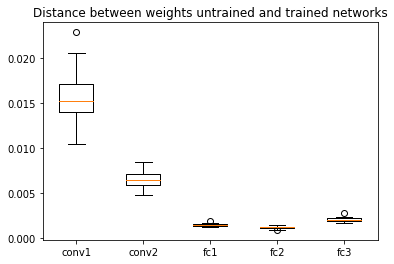

In [ ]:
print(results_bp)
labels, data = results_bp.keys(), results_bp.values()
plt.boxplot(data)
plt.title('Distance between weights untrained and trained networks')
plt.xticks(range(1, len(labels) + 1), labels)
plt.show()

{'conv1': [0.023877020925283432, 0.02142873965203762, 0.02542884275317192, 0.021753966808319092, 0.022416148334741592, 0.01638917624950409, 0.01856693997979164, 0.024176981300115585, 0.01840912736952305, 0.020916743203997612, 0.017691724002361298, 0.02213059365749359, 0.02802455797791481, 0.02313852310180664, 0.02175813913345337, 0.01969224587082863, 0.01819545030593872, 0.019366014748811722, 0.019393526017665863, 0.019496414810419083, 0.022518452256917953, 0.02610878273844719, 0.026445945724844933, 0.02413981780409813, 0.023494500666856766, 0.021045787259936333, 0.022114049643278122, 0.020998118445277214, 0.02374904975295067, 0.022563043981790543, 0.022086767479777336, 0.024776704609394073, 0.01706627756357193, 0.018263833597302437, 0.023759355768561363, 0.02062946930527687, 0.022093255072832108, 0.02280190959572792, 0.02978852391242981, 0.022269554436206818, 0.023174777626991272, 0.020666658878326416, 0.022721029818058014, 0.018960770219564438, 0.02169075980782509, 0.0227307789027690

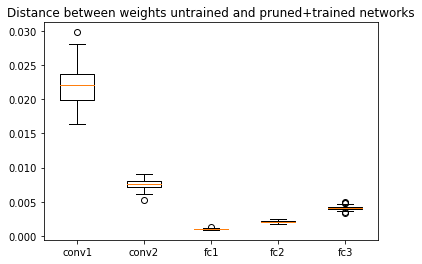

In [ ]:
print(results_ap)
labels, data = results_ap.keys(), results_ap.values()
plt.boxplot(data)
plt.title('Distance between weights untrained and pruned+trained networks')
plt.xticks(range(1, len(labels) + 1), labels)
plt.show()

In [ ]:
results_bp_df = pd.DataFrame.from_dict(results_bp)
results_ap_df = pd.DataFrame.from_dict(results_ap)

In [ ]:
results_bp_df.to_csv("results_bp_df.csv")
results_ap_df.to_csv("results_ap_df.csv")

In [ ]:
results_bp_df

Text(0.5, 1.0, 'Distributions of distances for untr vs tr and untr vs pr+tr')

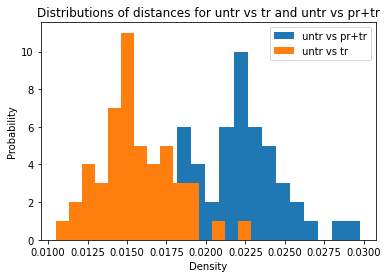

In [ ]:
plt.hist(results_ap_df['conv1'], density=False, bins=15)
plt.hist(results_bp_df['conv1'], density=False, bins=15)
plt.ylabel('Probability')
plt.xlabel('Density');
plt.legend(['untr vs pr+tr', 'untr vs tr'])
plt.title('Distributions of distances for untr vs tr and untr vs pr+tr')

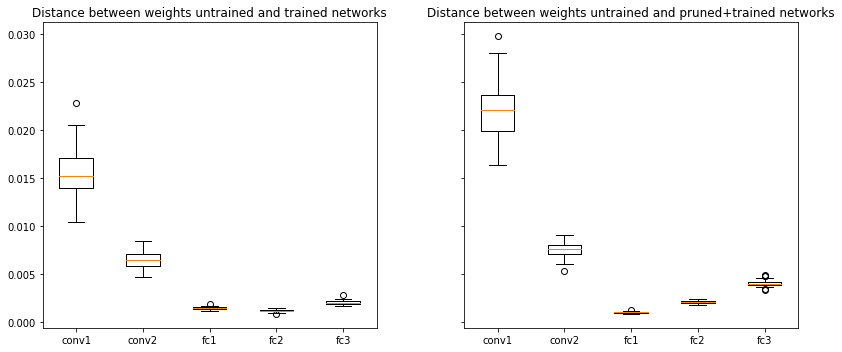

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12,5), sharey=True)

labels, data = results_bp.keys(), results_bp.values()
axs[0].boxplot(data)
axs[0].set_title('Distance between weights untrained and trained networks')

plt.sca(axs[0])
plt.xticks(range(1, len(labels) + 1), labels)

labels, data = results_ap.keys(), results_ap.values()
axs[1].boxplot(data)
axs[1].set_title('Distance between weights untrained and pruned+trained networks')

plt.sca(axs[1])
plt.xticks(range(1, len(labels) + 1), labels)

fig.tight_layout()

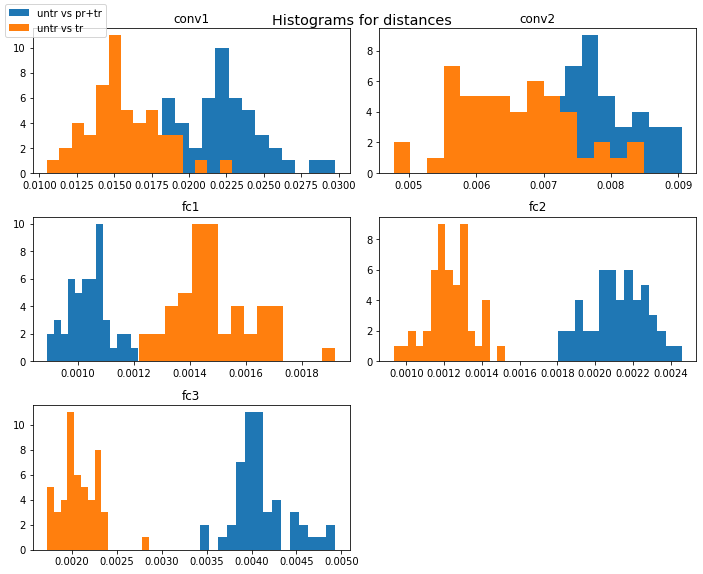

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(10,8))

axs[0, 0].hist(results_ap_df['conv1'], density=False, bins=15)
axs[0, 0].hist(results_bp_df['conv1'], density=False, bins=15)
axs[0, 0].set_title("conv1")

axs[0, 1].hist(results_ap_df['conv2'], density=False, bins=15)
axs[0, 1].hist(results_bp_df['conv2'], density=False, bins=15)
axs[0, 1].set_title("conv2")

axs[1, 0].hist(results_ap_df['fc1'], density=False, bins=15)
axs[1, 0].hist(results_bp_df['fc1'], density=False, bins=15)
axs[1, 0].set_title("fc1")

axs[1, 1].hist(results_ap_df['fc2'], density=False, bins=15)
axs[1, 1].hist(results_bp_df['fc2'], density=False, bins=15)
axs[1, 1].set_title("fc2")

axs[2, 0].hist(results_ap_df['fc3'], density=False, bins=15)
axs[2, 0].hist(results_bp_df['fc3'], density=False, bins=15)
axs[2, 0].set_title("fc3")

axs[2, 1].set_axis_off()

labels = ['untr vs pr+tr', 'untr vs tr']
fig.legend(labels, loc='upper left')
fig.suptitle('Histograms for distances', fontsize="x-large")

fig.tight_layout()